In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from scipy import interpolate
from time import sleep
from tqdm import tqdm
import seaborn as sns
import torch.nn.functional as F

In [ ]:
!pip install torchinfo

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
def Cumulative(wave):
    cu_list = []
    lists = wave.tolist()[0]
    length = len(lists)
    lists = [i**2 for i in lists]
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return np.array(cu_list[1:])

def FindValueIndex(seq, val):
    r = np.where(np.diff(np.sign(seq - val)) != 0)
    idx = r + (val - seq[r]) / (seq[r + np.ones_like(r)] - seq[r])
    idx = np.append(idx, np.where(seq == val))
    idx = np.sort(idx)
    return np.round(idx)

def FindTOF(wave):
  Ts = 2e-7
  Threshold = 0.25
  Cum_Amp_1 = Cumulative(wave)
  Cum_Amp_1_t = np.gradient(Cum_Amp_1,Ts*1e6)
  Target_Amp = np.max(Cum_Amp_1_t)*Threshold
  index = FindValueIndex(Cum_Amp_1_t,Target_Amp).astype(int)
  TOF = next(val for x, val in enumerate(Time_response[index]) if val > 145e-6)

  return TOF*1e6

def FindTOF_longwindow(wave):
  Ts = 2e-7
  Threshold = 0.25
  Long_response = np.arange(145e-6, 225e-6+Ts/2, Ts)
  Cum_Amp_1 = Cumulative(wave)
  Cum_Amp_1_t = np.gradient(Cum_Amp_1,Ts*1e6)
  Target_Amp = np.max(Cum_Amp_1_t)*Threshold
  index = FindValueIndex(Cum_Amp_1_t,Target_Amp).astype(int)
  TOF = next(val for x, val in enumerate(Long_response[index]) if val > 154e-6)
  return TOF*1e6

# GenerateSine(Peak-peak Amplitude,frequency,cycles)
def GenerateSine(A,freq,cycles):
  t = np.linspace(0, 50e-6, 251)
  Time = np.arange(0, cycles/freq/1e3, 2e-7)
  Amp = A / 2 * np.sin(2*np.pi*freq*1e3*Time)
  Amp = np.append(Amp,np.zeros(251-len(Time)))
  return Amp

def GenerateNoisySine(A,freq,cycles,sigma):
  t = np.linspace(0, 50e-6, 251)
  Time = np.arange(0, cycles/freq/1e3, 2e-7)
  Amp = A / 2 * np.sin(2*np.pi*freq*1e3*Time)
  noise_sigma = np.std(Amp)*sigma
  Amp = np.append(Amp,np.zeros(251-len(Time)))
  Amp = Amp + np.random.normal(0,noise_sigma,len(Amp))
  return Amp

# consider the specific heat ratio
def Cal_percentage(t_A,M_B,delta_t,gas):
    if gas == 'Air':
      k_B = 1.4 # air
    elif gas == 'Argon':
      k_B = 1.66 # argon
    M_A =  4.002602 #  Gas A: helium [g/mol]
    k_A = 1.66
    M_ratio = (M_B-M_A)/M_A
    t_ratio = (t_A/(t_A+delta_t))**2
    nume = k_A * (1-t_ratio)
    denu = t_ratio*k_A*M_ratio-k_B+k_A
    percentage = nume/denu # percentage (minus means delay)
    return percentage*100
'''
def Cal_deltaTOF(con_argon,con_air):

    R = 8.314 # individual gas constant (J/mol*K)
    T = 292 # absolute temperature (K)
    L = 150 # [mm]
    t_A = L / np.sqrt(1.66*R*T/(4.002602/1e3)) * 1e3
    k_M = (1.66*(100-con_argon-con_air)+1.66*con_argon+1.4*con_air)/100
    M_M = (4.002602*(100-con_argon-con_air)+39.948*con_argon+28.966*con_air)/100/1e3 # kg/mol
    c_M = np.sqrt(k_M*R*T/M_M)
    return (L / c_M * 1e3-t_A)
'''
def Cal_deltaTOF(con_argon, con_air):
    R = 8.314  # individual gas constant (J/mol*K)
    T = 292  # absolute temperature (K)
    L = 150  # [mm]
    t_A = L / np.sqrt(1.66 * R * T / (4.002602 / 1e3)) * 1e3
    k_M = (1.66 * (100 - con_argon - con_air) + 1.66 * con_argon + 1.4 * con_air) / 100
    M_M = (4.002602 * (100 - con_argon - con_air) + 39.948 * con_argon + 28.966 * con_air) / 100 / 1e3  # kg/mol
    c_M = np.sqrt(k_M * R * T / M_M)
    return (L / c_M * 1e3 - t_A)

def CalVolume(array,time,gas):
    MFC_Helium = 0.1646 #(sl/s) / V
    MFC_Air = 118.56  #(sccm/s) / V

    interval = time / len(array)
    if gas == 'Helium':
        volume = np.trapz(array * MFC_Helium, dx=interval)
    elif gas == 'Air':
        volume = np.trapz(array * MFC_Air, dx=interval)
    return(volume)

def compute_normalized_stft(signal, fs, window_size, overlap, max_frequency):
    frequencies, times, Zxx = stft(signal, fs=fs, window='hann', nperseg=window_size, noverlap=overlap)
    magnitude = np.abs(Zxx)

    max_freq_idx = np.argmax(frequencies > max_frequency)
    magnitude = magnitude[:max_freq_idx, :]

    magnitude_db = 20 * np.log10(np.maximum(magnitude, 1e-8))
    #magnitude_min = np.min(magnitude_db)
    #magnitude_max = np.max(magnitude_db)
    #magnitude_normalized = (magnitude_db - magnitude_min) / (magnitude_max - magnitude_min)

    return magnitude_db

def find_closest_con_air(con_argon, delta_TOF_truth):
    con_air_range = np.linspace(0, 1.2, 500)
    delta_TOFs = [Cal_deltaTOF(con_argon, con_air) for con_air in con_air_range]
    idx = np.argmin(np.abs(np.array(delta_TOFs) - delta_TOF_truth))
    return con_air_range[idx]

# Data Pre-processing

Read Excitations

In [ ]:
Excitation_set = []

In [ ]:
Ts = 2e-7
Time_exci = np.arange(0, 50e-6+Ts/2, Ts)
Time_exci

In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/Training_data_pure_helium/500khz

for n in range(275):
  x = np.loadtxt('C1--Trace-Helium-15cm--00'+str(f"{n:03}")+'.csv',dtype='float32',skiprows=5,delimiter=",")
  t0_index = np.argmin(abs(x[:,0]))
  t_end = np.argmin(abs(x[:,0]-50e-6))

  interpolator = interpolate.interp1d(x[t0_index:t_end,0], x[t0_index:t_end,1],kind='linear',fill_value=0,bounds_error=False)
  Interpolated_Excitation = interpolator(Time_exci)

  Excitation_set.append(list(Interpolated_Excitation))

/content/gdrive/.shortcut-targets-by-id/194AAoMald4Ypsq8mZ7vYTSA-BHCW4Wdm/AME508/Helium-Data/Training_data_pure_helium/500khz


In [ ]:
Excitation_set = np.array(Excitation_set)

In [ ]:
np.save('Excitation_set.npy',Excitation_set)

In [ ]:
test = GenerateSine(0.4,500,10)

(0.0, 50.0)

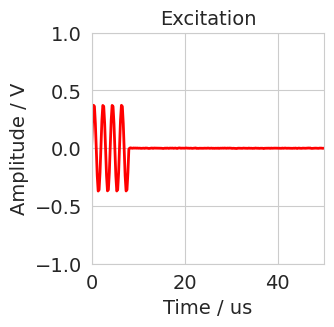

In [ ]:
from matplotlib import rcParams
plt.figure(figsize=(3,3),dpi=100)  # Figure size
mpl.rcParams.update({'font.size': 14})  # Global font size

idx = 26141

Time_plot = np.arange(0, 85e-6+Ts/2, Ts)
plt.plot(Time_plot*1e6,Response_test[idx:idx+1,426:].reshape(-1,1),linewidth=2,color='red')
#plt.plot(Time_exci*1e6,test.reshape(-1,1),linewidth=2,color='b')

plt.title('Excitation',fontsize=14)
plt.xlabel ('Time / us')
plt.ylabel ('Amplitude / V')
plt.ylim(-1,1)
plt.xlim(0,50)

Read Responses

In [ ]:
Response_set = []

In [ ]:
Time_response = np.arange(145e-6, 215e-6+Ts/2, Ts)

Time_response

In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/Training_data_pure_helium/600khz

for n in range(228):
  x = np.loadtxt('C2--Trace-Helium-15cm--00'+str(f"{n:03}")+'.csv',dtype='float32',skiprows=5,delimiter=",")

  t0_index = np.argmin(abs(x[:,0]-145e-6))
  t_end = np.argmin(abs(x[:,0]-215e-6))

  interpolator = interpolate.interp1d(x[t0_index:t_end,0], x[t0_index:t_end,1],kind='linear',fill_value=0,bounds_error=False)
  Interpolated_Response = interpolator(Time_response)

  Response_set.append(list(Interpolated_Response))

/content/gdrive/.shortcut-targets-by-id/194AAoMald4Ypsq8mZ7vYTSA-BHCW4Wdm/AME508/Helium-Data/Training_data_pure_helium/600khz


In [ ]:
Response_set = np.array(Response_set)

In [ ]:
np.save('Response_set.npy',Response_set)

(-1.0, 1.0)

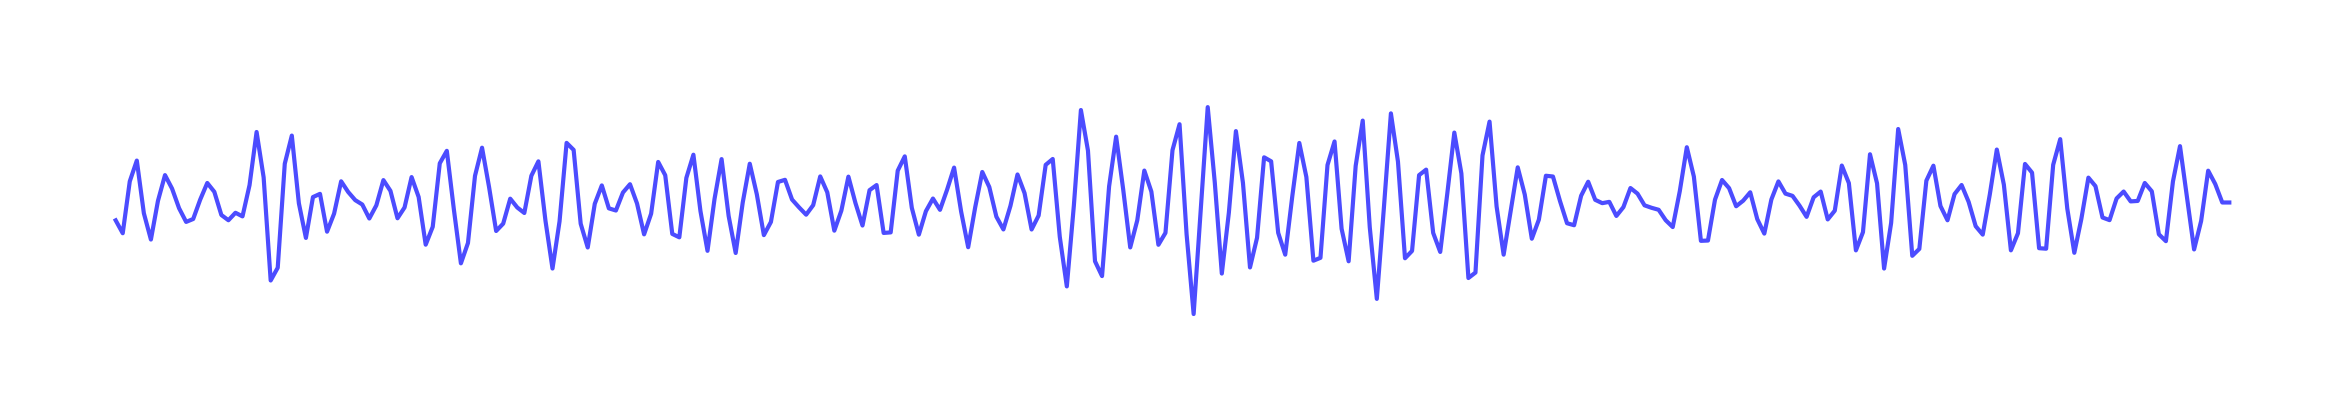

In [ ]:
plt.figure(figsize=(30,5),dpi=100)  # Figure size
mpl.rcParams.update({'font.size': 14})  # Global font size

plt.plot(Time_response*1e6,X_train[5:6,:].reshape(-1,1),linewidth=3,color='b',alpha=0.7)
#plt.xlabel (r"Time / $\it{\mu}$s"),plt.xlim(1000,1300)
#plt.ylabel ('Amplitude / V')
#plt.title('Response',fontsize=14)
plt.axis('off')
plt.ylim(-1,1)

# Load Pre-processed Data (Please RUN FROM HERE)

In [5]:
%cd /content/gdrive/MyDrive/CNN-Autoencoder-Impurity/FAN_Argon

X_train = np.load('X_train_helium(argon).npy')
Argon_Percentage = np.load('Argon_Percentage.npy')
Ts = 1e-6 # sampling interval
Time_response = np.arange(1000e-6, 1300e-6+Ts/2, Ts)

data = np.load("impurity_data.npz")
impurity_data_argon = {key: data[key] for key in data}

/content/gdrive/MyDrive/CNN-Autoencoder-Impurity/FAN_Argon


In [6]:
%cd /content/gdrive/MyDrive/CNN-Autoencoder-Impurity/FAN_Air

X_train_1 = np.load('X_train_helium(air).npy')
X_train = np.vstack((X_train,X_train_1))
Air_Percentage = np.load('Air_Percentage.npy')

data = np.load("impurity_data.npz")
impurity_data_air = {key: data[key] for key in data}

/content/gdrive/MyDrive/CNN-Autoencoder-Impurity/FAN_Air


# Create custom dataset class

In [11]:
class DataSet(torch.utils.data.Dataset):
  def __init__(self, ds):
    self.data = ds

  def __len__(self):
    return len(self.data[:,:])

  def __getitem__(self, idx):
    data = self.data[idx]
    return data

# Create dataset generator

In [12]:
# Generators
batch_size = 512
trainingData = DataSet(X_train_with_TOF)
training_generator = torch.utils.data.DataLoader(trainingData,batch_size=batch_size,shuffle=True)

# Build and Train Neural Network

In [13]:
import torch.nn.functional as F

class WAE(nn.Module):
    def __init__(self):
        super(WAE, self).__init__()
        self.activation = nn.ReLU()
        # Encoder
        self.fc1 = nn.Linear(302, 20)
        self.fc2 = nn.Linear(20, 10)

        # Decoder
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, 302)

    def encoder(self, x):
        # Encoder
        x = self.fc1(x)
        x = self.activation(x)
        z = self.fc2(x)
        return z

    def decoder(self, z):
        # Decoder
        y = self.fc3(z)
        y = self.activation(y)
        y = self.fc4(y)
        return y

    def forward(self, x):
        latent_z = self.encoder(x.view(-1, 302))
        return self.decoder(latent_z),latent_z

In [ ]:
from torchinfo import summary

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device: ",device)
WAE().to(device)

print(summary(WAE().to(device), input_size=(302,)))

Device:  cpu
Layer (type:depth-idx)                   Output Shape              Param #
WAE                                      [1, 302]                  --
├─Linear: 1-1                            [1, 20]                   6,060
├─ReLU: 1-2                              [1, 20]                   --
├─Linear: 1-3                            [1, 2]                    42
├─Linear: 1-4                            [1, 20]                   60
├─ReLU: 1-5                              [1, 20]                   --
├─Linear: 1-6                            [1, 302]                  6,342
Total params: 12,504
Trainable params: 12,504
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05


In [14]:
def mmd_penalty(sample_qz, sample_pz,device):
    sigma2_p = 1.0
    batch_size = len(sample_qz)

    n = batch_size
    nf = n*1.0

    sample_qz = torch.squeeze(sample_qz)
    sample_pz = torch.squeeze(sample_pz)

    z_dim = len(sample_qz[0])

    norms_pz = torch.sum(torch.square(sample_pz), dim=1, keepdim=True)
    dotprods_pz = torch.matmul(sample_pz, torch.transpose(sample_pz, 0, 1))
    distances_pz = norms_pz + torch.transpose(norms_pz,0,1) - 2.0 * dotprods_pz

    norms_qz = torch.sum(torch.square(sample_qz), dim=1, keepdim=True)
    dotprods_qz = torch.matmul(sample_qz, torch.transpose(sample_qz, 0, 1))
    distances_qz = norms_qz + torch.transpose(norms_qz,0,1) - 2.0 * dotprods_qz

    dotprods = torch.matmul(sample_qz, torch.transpose(sample_pz, 0, 1))
    distances = norms_qz + torch.transpose(norms_pz,0,1) - 2.0 * dotprods

    C = 2.0 * z_dim * sigma2_p
    stat = 0.0
    res1 = C / (C + distances_qz)
    res1 += C / (C + distances_pz)
    res1 = torch.multiply(res1, 1.0 - torch.eye(n).to(device))
    res1 = torch.sum(res1) / (nf * nf - nf)
    res2 = C / (C + distances)
    res2 = torch.sum(res2) * 2.0 / (nf * nf)
    stat += (res1 - res2)
    return stat

def compute_mmd(z, device,lambda_param):
    z = torch.squeeze(z)
    z_prior = torch.randn(len(z),len(z[0])).to(device)
    mmd_pen = mmd_penalty(z, z_prior,device)
    return lambda_param*mmd_pen

alpha = 0.0001
def loss_function(recon_x, x):
    BCE_signal = F.l1_loss(recon_x[:,:-1], x.view(-1, 302)[:,:-1],reduction='sum')
    BCE_TOF = F.mse_loss(recon_x[:,-1], x.view(-1, 302)[:,-1],reduction='sum') # always return one value, during training it's across signal length and batch size

    return BCE_signal + alpha * BCE_TOF, BCE_signal, alpha * BCE_TOF

In [ ]:
# Checking if the mmd implementation is correct: pdfs which are close to each other should give close to zero distance!
pdf1 = torch.randn(1000,5).to(device)
s=1;m=0
pdf2 = s*torch.randn(1000,5).to(device)+m

mmd_pen = mmd_penalty(pdf1, pdf2,device)
print(mmd_pen)

# Training

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# create the model
wae = WAE().to(device)

max_epochs = 500

optimizer = optim.Adam(wae.parameters(), lr=1e-4, betas=(0.9, 0.999))
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

train_loss = []
mmd_pen = []
signal_loss_list = []
TOF_loss_list = []

for epoch in tqdm(range(max_epochs)):
  for index, data in enumerate(training_generator):

    inputs_train = data[:,:].to(torch.float32).to(device)
    groundtruth_train = data[:,:].reshape(-1,1).to(torch.float32).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # make prediction and evaluate loss
    prediction,latentz = wae(inputs_train)

    # evaluate loss
    tran_loss = loss_function(prediction, groundtruth_train)[0] # RE
    signal_loss = loss_function(prediction, groundtruth_train)[1]
    TOF_loss = loss_function(prediction, groundtruth_train)[2]

    mmd_loss = compute_mmd(latentz,device,lambda_param=1e4) # as lambda increases, the latent space better approximate 0-mean and 1-std,
                                      #but it get less distinguiable in the latent space for abnormal status
    loss = tran_loss + mmd_loss

    # find the gradients using back-propagation
    loss.backward()

    # update the weights
    optimizer.step()

  train_loss.append(tran_loss.item())
  mmd_pen.append(mmd_loss.item())
  signal_loss_list.append(signal_loss.item()) # ONLY last batch!!
  TOF_loss_list.append(TOF_loss.item()) # ONLY last batch!!

  sleep(0)

cpu


100%|██████████| 500/500 [00:48<00:00, 10.26it/s]


In [ ]:
PATH = './WAE-TOF-10-LatentSpace.pth'
torch.save(wae.state_dict(), PATH)

In [15]:
%cd /content/gdrive/MyDrive/CNN-Autoencoder-Impurity

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

PATH = './WAE-TOF-10-LatentSpace.pth'

# create the model
wae = WAE().to(device)

wae.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

/content/gdrive/MyDrive/CNN-Autoencoder-Impurity
cpu


<All keys matched successfully>

# Visualization

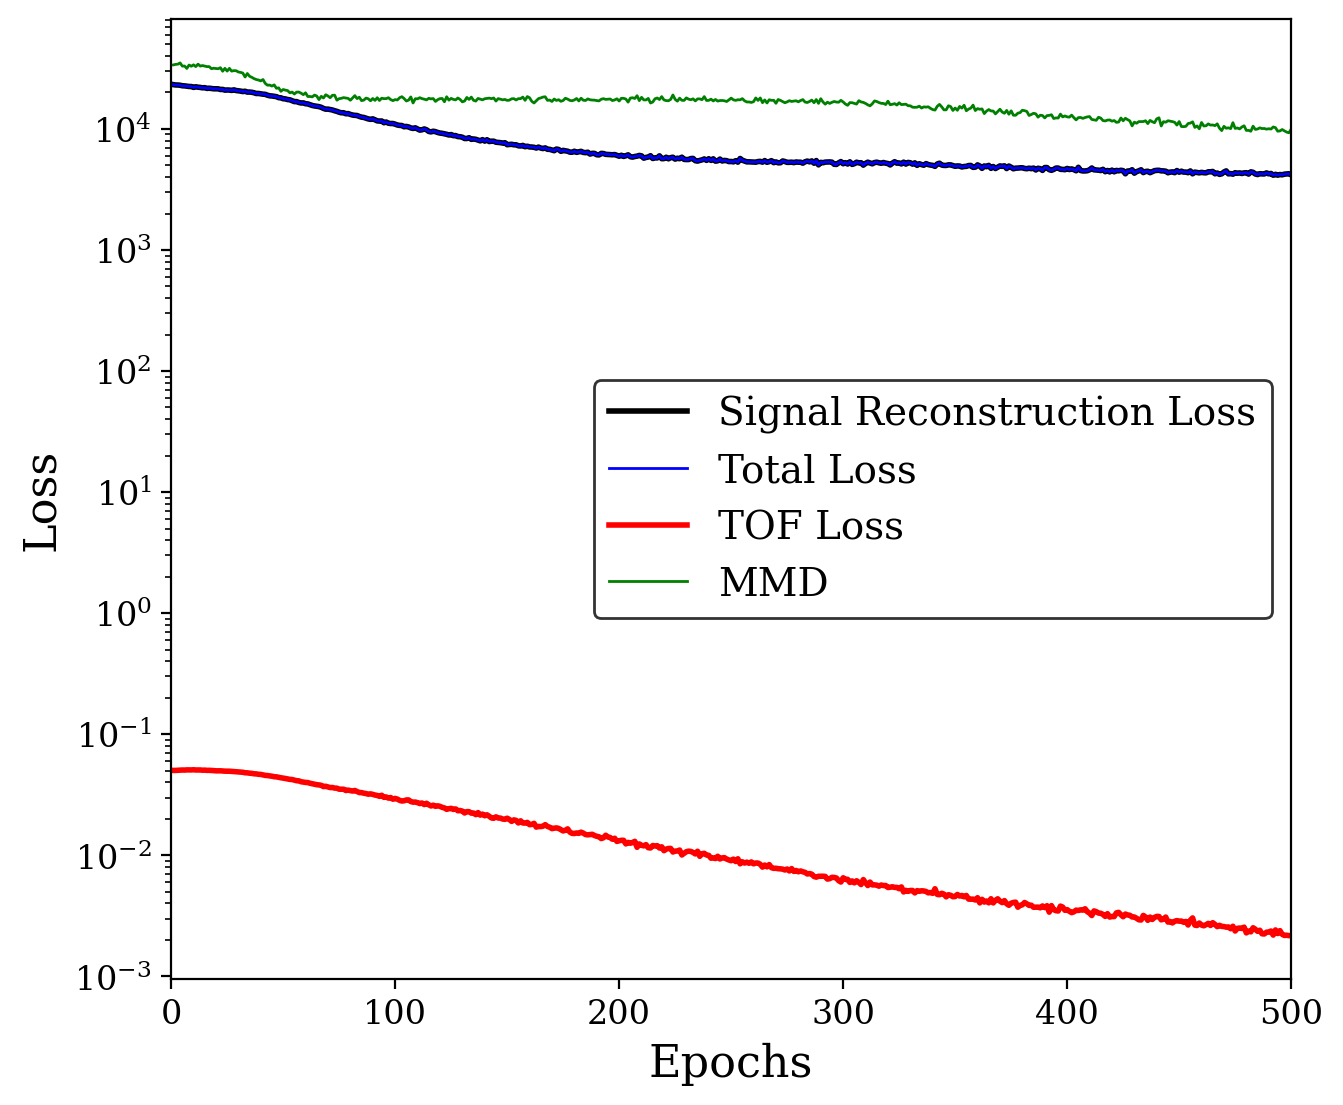

In [ ]:
nc = 1; nr = 1;
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(7*nc,6*nr),dpi=200)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.5)

epoNum = np.arange(1,max_epochs+1)
plt.plot(epoNum,signal_loss_list,'-k',linewidth = 2,label='Signal Reconstruction Loss')
plt.plot(epoNum,train_loss,'-b',linewidth = 1,label='Total Loss')
plt.plot(epoNum,TOF_loss_list,'-r',linewidth = 2,label='TOF Loss')
plt.plot(epoNum,mmd_pen,'-g',linewidth = 1,label='MMD')

ax.legend(loc='center right',edgecolor='k',fontsize=14,frameon=True,ncol=1)
ax.set_xlabel('Epochs',fontsize=16)
ax.set_ylabel('Loss',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim([0, max_epochs])
#ax.set_ylim([1000, 10000])
plt.yscale('log')
plt.rcdefaults()

In [ ]:
# plot the output vs ground truth

The concentration is 0.8081915919752035%


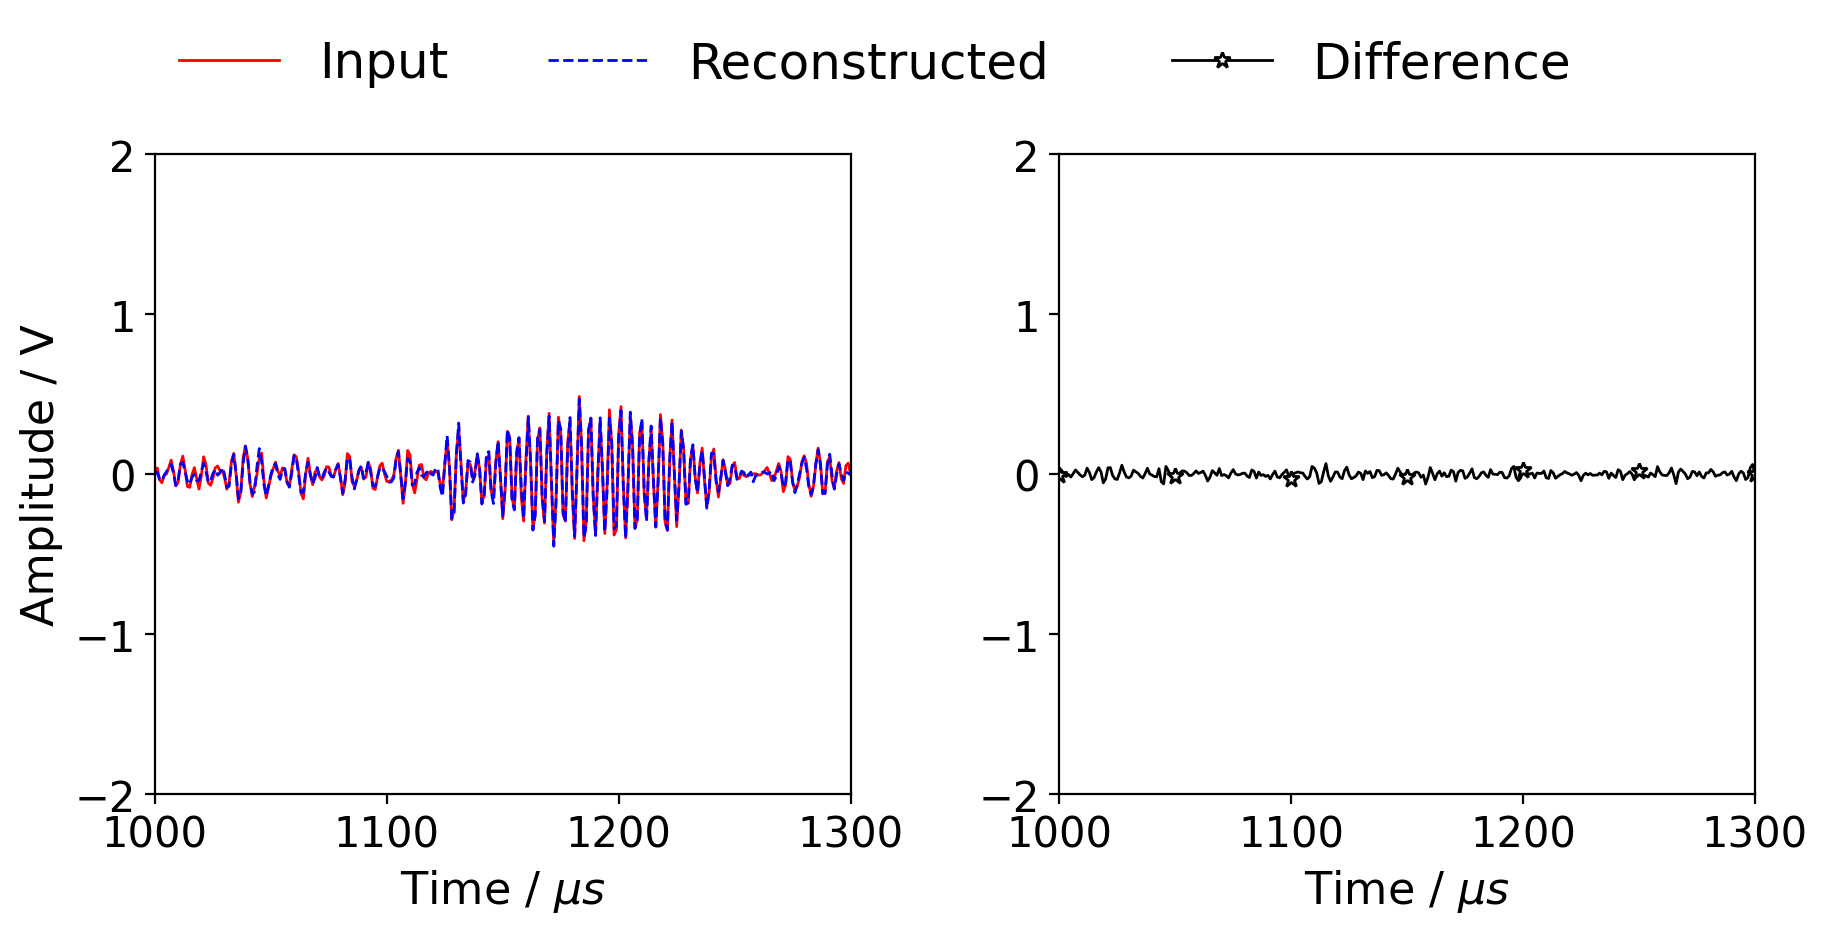

In [ ]:
nr = 1
nc = 2

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
#plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(5*nc,4*nr),dpi=200)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.4)
ax = ax.flatten()

Signal_used = X_train_with_TOF[700:701]
#concen_idx = 25
#Signal_used = impurity_data_argon[f'Impurity_Argon_{concen_idx}']

for idx in range(nr*nc):
  if idx%2 == 0:
    Wave_idx = np.random.randint(Signal_used.shape[0])
    with torch.no_grad():
      test_inputs_branch = torch.from_numpy(Signal_used[Wave_idx:Wave_idx+1,:]).to(torch.float32).to(device)
      #test_inputs_branch = torch.reshape(test_inputs_branch, (test_inputs_branch.size(dim=0), 1, 301))
      test_prediction,_ = wae(test_inputs_branch)
      test_prediction = test_prediction.cpu().detach().numpy()

    ax[idx].plot(Time_response*1e6,Signal_used[Wave_idx:Wave_idx+1,:-1].reshape(-1,1),'r',linewidth = 1,label='Input')
    ax[idx].plot(Time_response*1e6,test_prediction[:,:-1].reshape(-1,1),'--b',linewidth = 1,label='Reconstructed')
    ax[idx].set_xlabel('Time / $\mu s$',fontsize=16);ax[idx].set_xlim(1000,1300);ax[idx].set_ylim(-2,2)
    ax[nr*nc-2].legend(bbox_to_anchor=(1.35, 1.25),edgecolor='k',fontsize=18,frameon=False,ncol=2)
    if idx%4 == 0:
      ax[idx].set_ylabel('Amplitude / V',fontsize=16)

  else:
    Difference = Signal_used[Wave_idx:Wave_idx+1,:-1].reshape(-1,1)-test_prediction[:,:-1].reshape(-1,1)
    ax[idx].plot(Time_response*1e6,Difference,'-*k',markevery=50,markerfacecolor='w',linewidth = 1,label='Difference')
    ax[idx].set_xlabel('Time / $\mu s$',fontsize=16);ax[idx].set_xlim(1000,1300);ax[idx].set_ylim(-2,2)
    #ax[idx].legend(loc='lower right',edgecolor='k',fontsize=14,frameon=True,ncol=1)
    #Wave_idx += 1
print(f'The concentration is {Air_Percentage[concen_idx][0]}%')
plt.legend(bbox_to_anchor=(0.8, 1.25),edgecolor='k',fontsize=18,frameon=False,ncol=1)

In [ ]:
def FindRE_Mean_and_std(Signal_used):
    with torch.no_grad():
        test_inputs_branch = torch.from_numpy(Signal_used).to(torch.float32).to(device)
        #test_inputs_branch = torch.reshape(test_inputs_branch, (test_inputs_branch.size(dim=0), 1, 302))
        test_prediction = wae(test_inputs_branch)[0].cpu().detach().numpy()

    signal_mae_errors = np.sum(np.abs(test_prediction[:,:-1] - Signal_used[:,:-1]), axis=1)
    TOF_MSE_errors = (test_prediction[:,-1] - Signal_used[:,-1])**2

    total_mae_errors = signal_mae_errors + alpha * TOF_MSE_errors

    return np.mean(total_mae_errors),np.std(total_mae_errors),np.mean(signal_mae_errors),np.std(signal_mae_errors),np.mean(alpha*TOF_MSE_errors),np.std(alpha*TOF_MSE_errors)

In [ ]:
alpha = 100

mean_list = []; std_list = []

Signal_used = X_train_with_TOF[:]
mean_list.append(FindRE_Mean_and_std(Signal_used)[0])
std_list.append(FindRE_Mean_and_std(Signal_used)[1])

for i in range(1, 41):  # Loop from 1 to 40
    #Signal_used = impurity_data_air[f'Impurity_Air_{i}']
    Signal_used = impurity_data_argon[f'Impurity_Argon_{i}']
    mean_list.append(FindRE_Mean_and_std(Signal_used)[0])
    std_list.append(FindRE_Mean_and_std(Signal_used)[1])

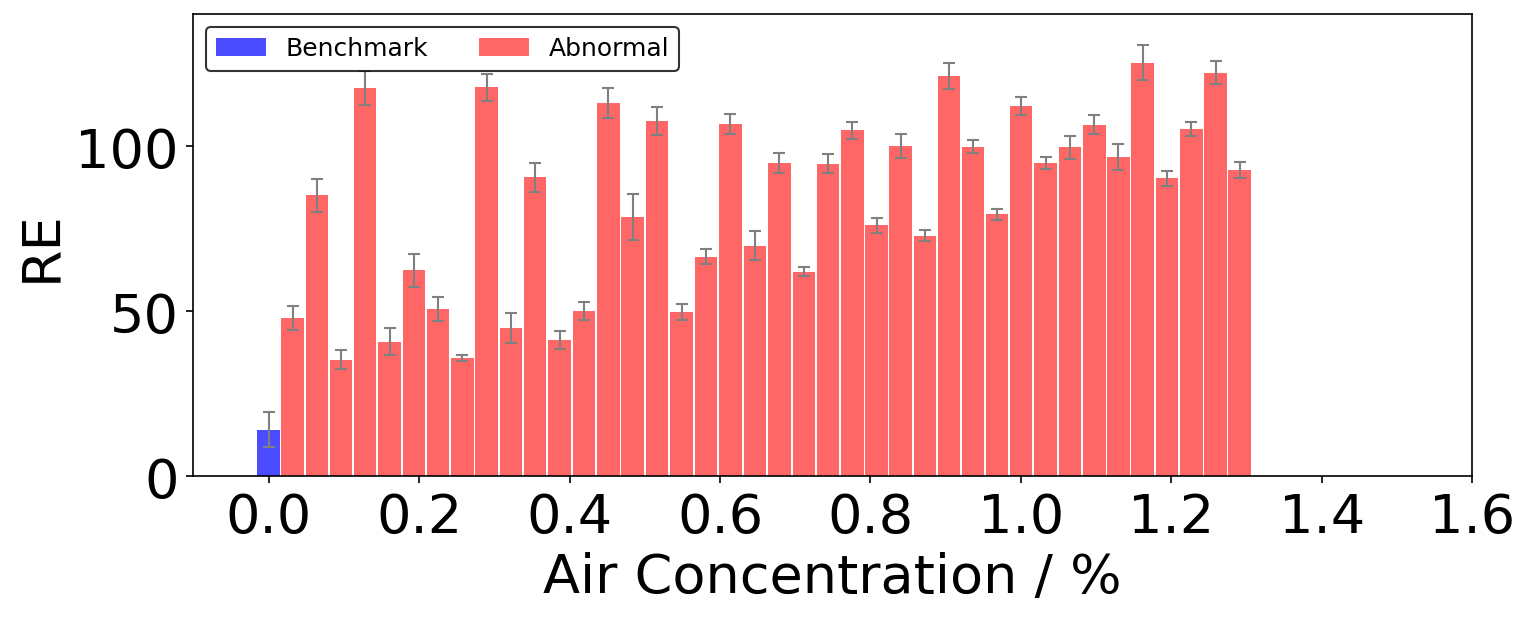

In [ ]:
plt.figure(figsize=(11, 4), dpi=150)
label_for_benchmark_added = False
label_for_impurities_added = False

# Creating a bar chart with error bars
for i in range(len(mean_list)):
    if i == 0:
        # First bar in blue
        plt.bar(Air_Percentage[i], mean_list[i], yerr=std_list[i:i+1], capsize=3, alpha=0.7, width=0.03,
                color='b', edgecolor='b', linewidth=0,
                error_kw={'elinewidth': 1, 'ecolor': 'grey'},label='Benchmark' if not label_for_benchmark_added else '')
        label_for_benchmark_added = True
    else:
        # Other bars in a different color
        plt.bar(Air_Percentage[i], mean_list[i], yerr=std_list[i:i+1], capsize=3, alpha=0.6, width=0.03,
                color='r', edgecolor='r', linewidth=0,
                error_kw={'elinewidth': 1, 'ecolor': 'grey'},label='Abnormal' if not label_for_impurities_added else '')
        label_for_impurities_added = True

# Setting labels and title
plt.xlabel('Air Concentration / %', fontsize=26)
plt.ylabel('RE', fontsize=26)
plt.legend(loc='upper left', edgecolor='k', fontsize='large', frameon=True, ncol=2)
plt.xlim(-0.1, 1.6)
plt.ylim(0, 140)  # Adjust y-axis limit to fit the data
#plt.yticks(np.arange(0, 0.3, 0.05))
plt.xticks(np.arange(0, 1.8, 0.2))
plt.tick_params(axis='both', labelsize=26)
plt.show()

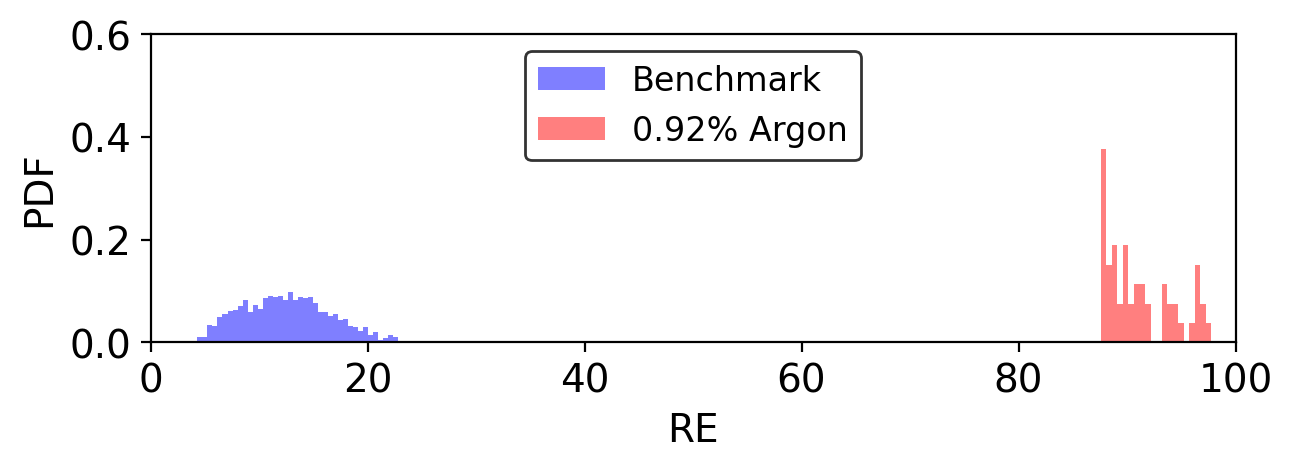

In [17]:
plt.figure(figsize=(7,2),dpi=200)  # Figure size
alpha = 100

with torch.no_grad():
    test_inputs_branch = torch.from_numpy(X_train_with_TOF).to(torch.float32).to(device)
    test_inputs_branch = torch.reshape(test_inputs_branch, (test_inputs_branch.size(dim=0), 1, 302))
    test_prediction = wae(test_inputs_branch)[0].cpu().detach().numpy()

kwargs = dict(alpha=0.5, bins=100)

signal_mae_errors = np.sum(np.abs(test_prediction[:,:-1] - X_train_with_TOF[:,:-1]), axis=1)
TOF_MSE_errors = (test_prediction[:,-1] - X_train_with_TOF[:,-1])**2

total_errors = signal_mae_errors + alpha * TOF_MSE_errors

plt.hist(total_errors, **kwargs,color = 'b',label='Benchmark',density=True)

## plot impurity
concen_idx = 24
Signal_used = impurity_data_argon[f'Impurity_Argon_{concen_idx}']

with torch.no_grad():
    test_inputs_branch = torch.from_numpy(Signal_used).to(torch.float32).to(device)
    test_inputs_branch = torch.reshape(test_inputs_branch, (test_inputs_branch.size(dim=0), 1, 302))
    test_prediction = wae(test_inputs_branch)[0].cpu().detach().numpy()

signal_mae_errors = np.sum(np.abs(test_prediction[:,:-1] - Signal_used[:,:-1]), axis=1)
TOF_MSE_errors = (test_prediction[:,-1] - Signal_used[:,-1])**2

total_errors = signal_mae_errors + alpha * TOF_MSE_errors

kwargs = dict(alpha=0.5, bins=20)
plt.hist(total_errors, **kwargs,color = 'r',label=f'{Argon_Percentage[concen_idx][0]:.2f}% Argon',density=True)
plt.xlabel('RE', fontsize=14)
plt.ylabel('PDF', fontsize=14)

#plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
#plt.gca().ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.legend(loc='upper center',edgecolor='k',fontsize='large',frameon=True,ncol=1)
plt.tick_params(axis='both', labelsize=14)
plt.xlim(0,100)
plt.ylim(0,0.6)
plt.show()

In [ ]:
print(np.mean(latent_X_train,axis=0))
print(np.std(latent_X_train,axis=0))

[ 0.07741953 -0.11310598]
[0.93518704 0.87115604]


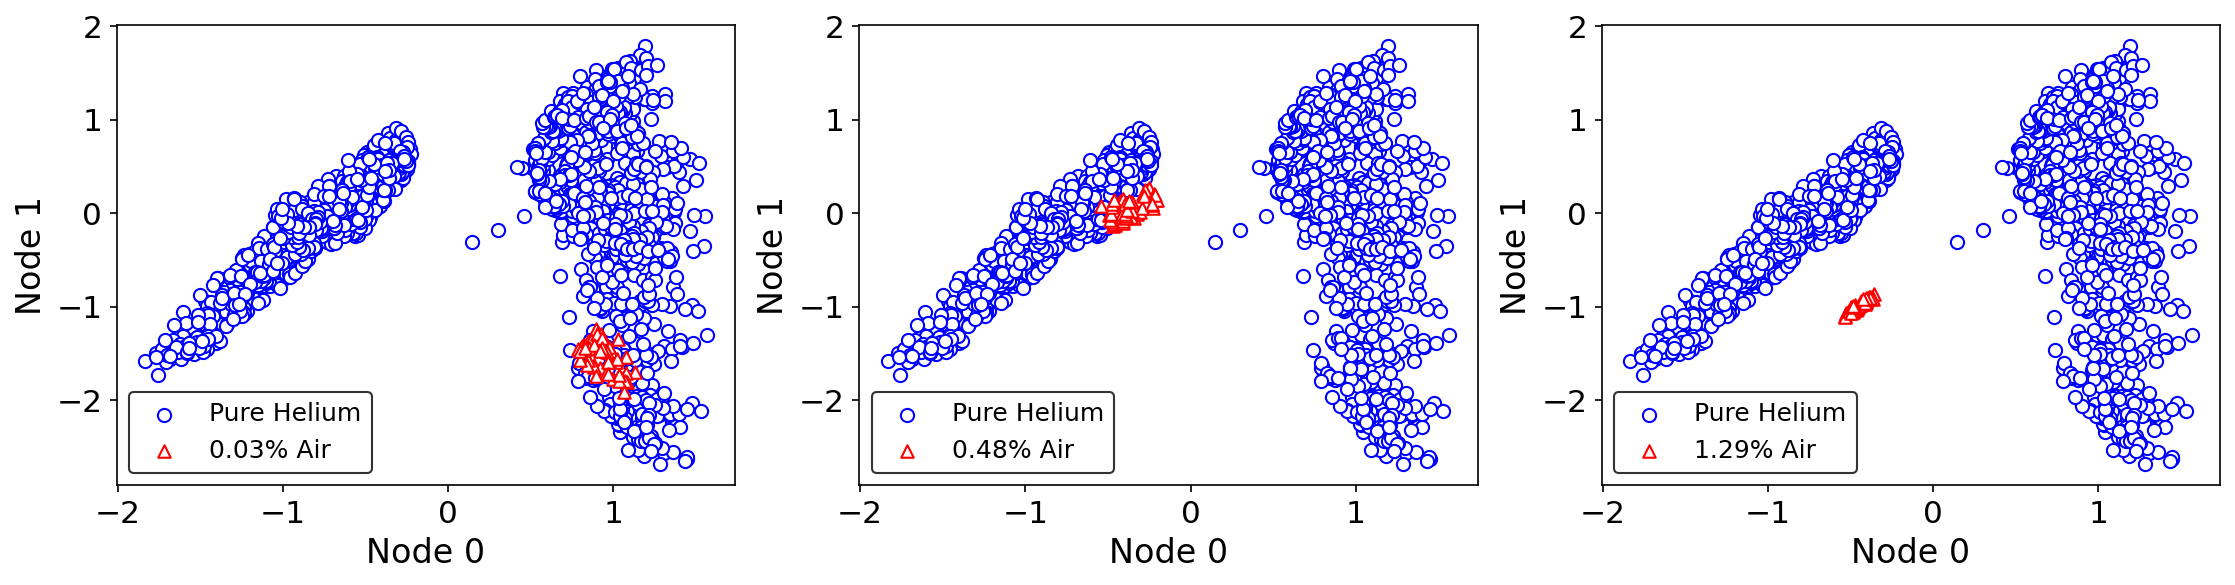

In [ ]:
plt.figure(figsize=(15, 4), dpi=150)

Node_idx_1 = 0
Node_idx_2 = 1

for index, i in enumerate([1, 15, 40], start=1):
    impure_signal = impurity_data_argon[f'Impurity_Argon_{i}']
    #impure_signal = impurity_data_air[f'Impurity_Air_{i}']

    # Encode the impure signal to latent space without gradient calculations
    with torch.no_grad():
        _,latent_signal_used = wae(torch.Tensor(impure_signal).to(device))
        latent_signal_used = latent_signal_used.cpu().numpy()

    if index == 1:  # Check if it's the first iteration
        with torch.no_grad():
            _,latent_X_train = wae(torch.Tensor(X_train_with_TOF[:]).to(device))
            latent_X_train = latent_X_train.cpu().numpy()

    plt.subplot(1, 3, index)
    plt.scatter(latent_X_train[:, Node_idx_1], latent_X_train[:, Node_idx_2], edgecolors='b', facecolors='white', s=40, label='Pure Helium')

    plt.scatter(latent_signal_used[:, Node_idx_1], latent_signal_used[:, Node_idx_2], marker='^', edgecolors='r', facecolors='white', label=f'{Air_Percentage[i][0]:.2f}% Air')
    plt.legend(loc='lower left', edgecolor='k', fontsize='large', frameon=True, ncol=1)

    #plt.xlim(-0.5, 1.5)
    #plt.ylim(-0.2, 0.1)
    #plt.xticks(np.arange(0, 1.8, 0.3))
    #plt.yticks(np.arange(0, 1.8, 0.3))
    plt.xlabel(f'Node {Node_idx_1}', fontsize=16)
    plt.ylabel(f'Node {Node_idx_2}', fontsize=16)

plt.tight_layout()  # Adjust the layout
plt.show()

In [ ]:
print(np.mean(latent_X_train,axis=0))
print(np.std(latent_X_train,axis=0))

[ 0.00302343 -0.04903721 -0.2786151   0.25384152  0.16841066 -0.083404
  0.10607316  0.1407922   0.13709217  0.022108  ]
[0.77564883 0.66808885 1.2721688  1.2142756  0.9850751  0.5635567
 0.90543437 0.70923966 0.7980019  0.50430155]


<ipython-input-605-b6db3788d651>:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, Air_Percentage[40][0], 8))


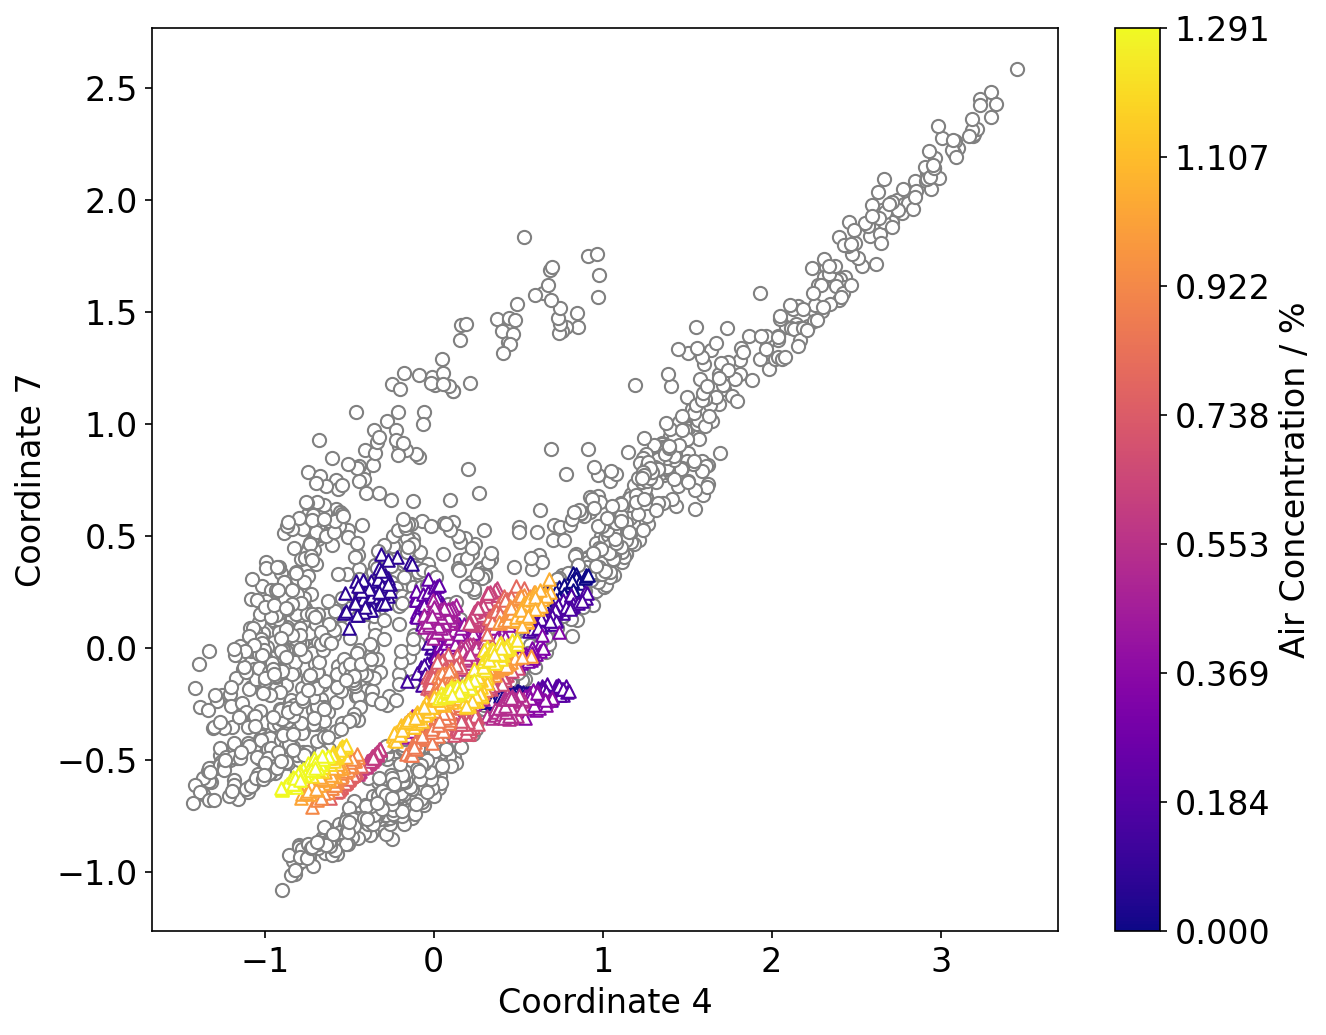

In [ ]:
plt.figure(figsize=(9, 7), dpi=150)
Node_idx_1 = 4
Node_idx_2 = 7
colors = plt.cm.plasma(np.linspace(0, 1, 40))  # Gradient color map

with torch.no_grad():
    _,latent_X_train = wae(torch.Tensor(X_train_with_TOF[:]))  # Only use the means
    latent_X_train = latent_X_train.numpy()

    plt.scatter(latent_X_train[:, Node_idx_1], latent_X_train[:, Node_idx_2],
              edgecolors='grey', facecolors='white', s=40, label='Benchmark')

for i in range(1, 41):
    impure_signal = impurity_data_argon[f'Impurity_Argon_{i}']
    #impure_signal = impurity_data_air[f'Impurity_Air_{i}']

    # Assume the VAE and the following operations are correctly defined
    with torch.no_grad():
        _,latent_signal_used = wae(torch.Tensor(impure_signal))  # Only use the means
        latent_signal_used = latent_signal_used.numpy()

    plt.scatter(latent_signal_used[:, Node_idx_1], latent_signal_used[:, Node_idx_2],
            marker='^', edgecolors=colors[i-1], facecolors='white',
            label='Argon')

sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=Air_Percentage[0][0], vmax=Air_Percentage[40][0]))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0, Air_Percentage[40][0], 8))
cbar.set_label('Air Concentration / %', fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.xlabel(f'Coordinate {Node_idx_1}', fontsize=16)
plt.ylabel(f'Coordinate {Node_idx_2}', fontsize=16)
plt.tick_params(axis='both', labelsize=16)
#plt.legend(loc='upper right', edgecolor='k', fontsize='large', frameon=True, ncol=1)
#plt.xlim(-0.8, 0.8)
#plt.ylim(-1.2, 1.2)
plt.tight_layout()
plt.show()

USE VAE to generate new data similar to Training set

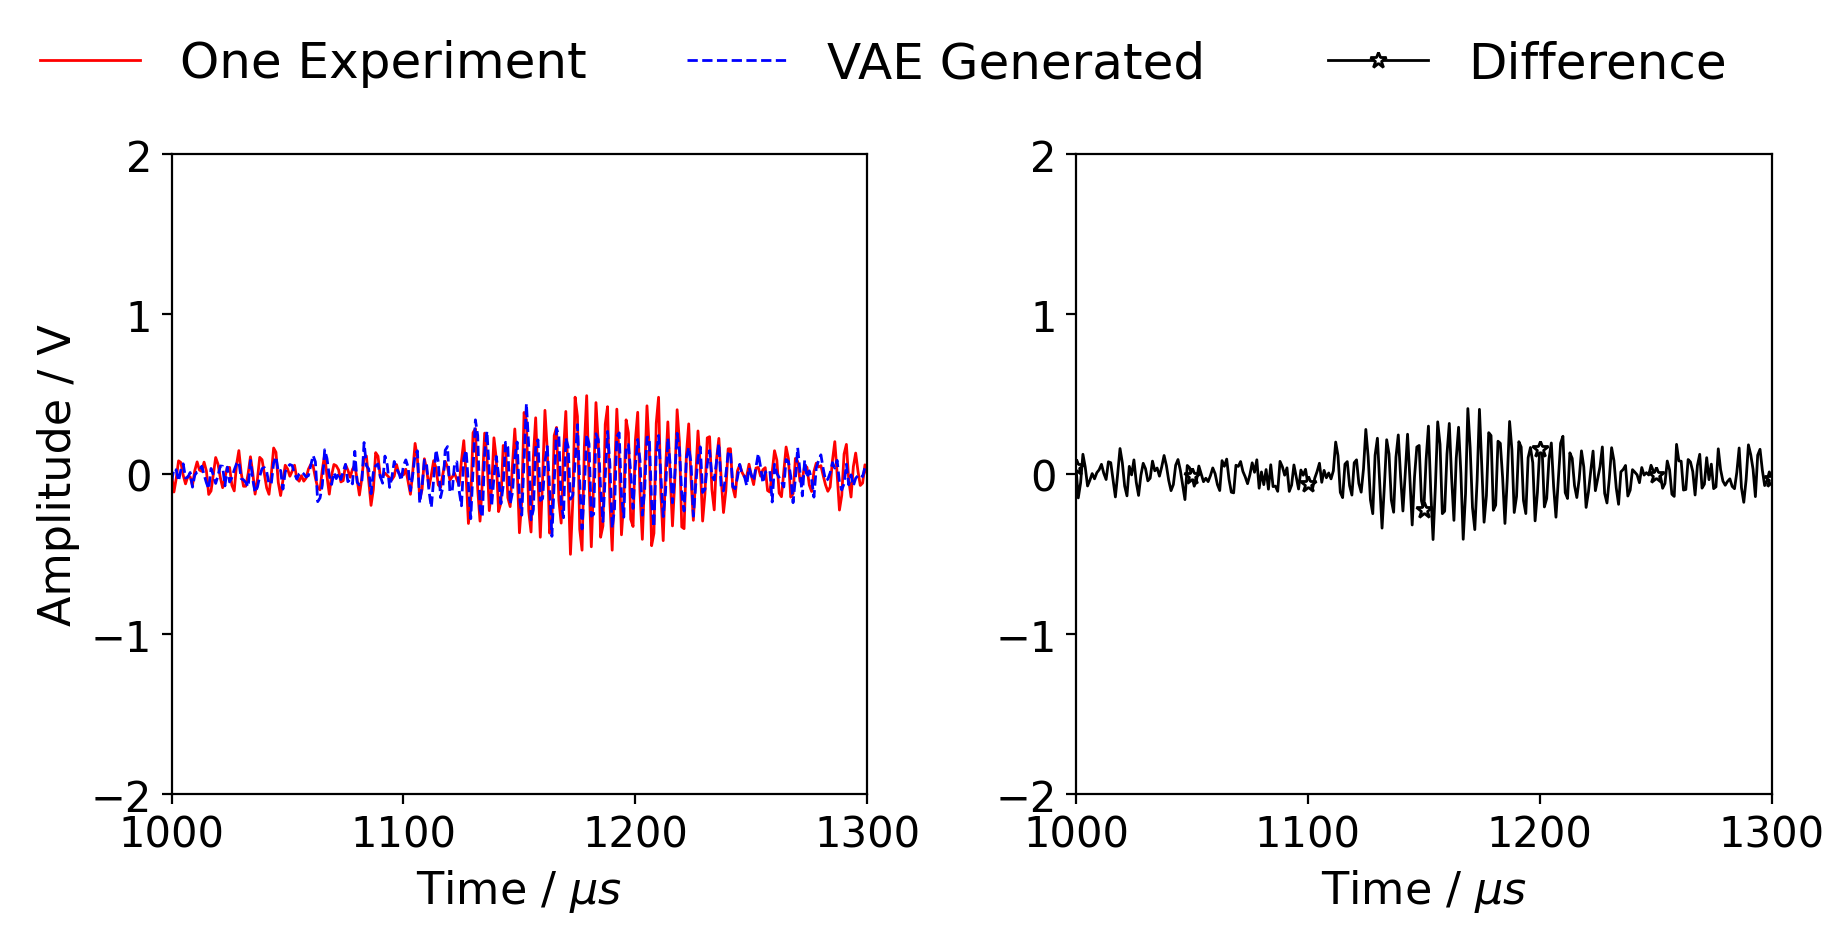

In [ ]:
num_samples = 1000  # You can change this as needed

# Assuming the latent space is a Gaussian with mean 0 and variance 1
z = torch.randn(num_samples, 10).to(device)
#z[:, 0] -= 1

# Decode the sample
with torch.no_grad():
    generated_data = wae.decoder(z).cpu().numpy()
    averaged_data = np.mean(generated_data, axis=0)

nr = 1
nc = 2

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
#plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(5*nc,4*nr),dpi=200)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.4)
ax = ax.flatten()

experiments = X_train_with_TOF[500,:]
VAE_data = averaged_data #generated_data[50]

for idx in range(nr*nc):
  if idx%2 == 0:
    ax[idx].plot(Time_response*1e6,experiments[:-1],'r',linewidth = 1,label='One Experiment')
    ax[idx].plot(Time_response*1e6,VAE_data[:-1],'--b',linewidth = 1,label='VAE Generated')

    ax[idx].set_xlabel('Time / $\mu s$',fontsize=16);ax[idx].set_xlim(1000,1300);ax[idx].set_ylim(-2,2)
    ax[nr*nc-2].legend(bbox_to_anchor=(1.55, 1.25),edgecolor='k',fontsize=18,frameon=False,ncol=2)
    if idx%4 == 0:
      ax[idx].set_ylabel('Amplitude / V',fontsize=16)

  else:
    Difference = experiments[:-1]-VAE_data[:-1]
    ax[idx].plot(Time_response*1e6,Difference,'-*k',markevery=50,markerfacecolor='w',linewidth = 1,label='Difference')
    ax[idx].set_xlabel('Time / $\mu s$',fontsize=16);ax[idx].set_xlim(1000,1300);ax[idx].set_ylim(-2,2)

plt.legend(bbox_to_anchor=(1, 1.25),edgecolor='k',fontsize=18,frameon=False,ncol=1)

# ADD TOF to DATA

In [7]:
TOF_mean = []

max_amplitude_indices = np.argmax(X_train[:], axis=1)
TOF = Time_response[max_amplitude_indices] *1e3
TOF_mean.append(np.mean(TOF))

In [8]:
TOF_reshaped = TOF.reshape((-1, 1))

# Append TOF as the last column to X_train
X_train_with_TOF = np.hstack((X_train, TOF_reshaped))
X_train_with_TOF.shape

(1991, 302)

In [10]:
for i in range(1, 41):  # Loop from 1 to 40
    #Signal_used = impurity_data_air[f'Impurity_Air_{i}']
    Signal_used = impurity_data_argon[f'Impurity_Argon_{i}']
    max_amplitude_indices = np.argmax(Signal_used, axis=1)
    TOF = Time_response[max_amplitude_indices] * 1e3
    TOF_reshaped = TOF.reshape((-1, 1))
    Signal_with_TOF = np.hstack((Signal_used, TOF_reshaped))

    #impurity_data_air[f'Impurity_Air_{i}'] = Signal_with_TOF
    impurity_data_argon[f'Impurity_Argon_{i}'] = Signal_with_TOF